In [1]:
from da_od.config import test_img
from da_od.model import DepthAnythingEstimator, MiDaSEstimator, MonocularDepthEstimator

image_path = test_img / "DALLE.jpeg"

In [2]:
DepthAnything_estimator = DepthAnythingEstimator(image_path, encoder="vits")
DepthAnything_colored, DepthAnything_raw = DepthAnything_estimator.process_image()

INFO:dinov2:using MLP layer as FFN


In [3]:
# MiDaS_estimator = MiDaSEstimator(image_path, model_type="DPT_Large")
# MiDaS_colored, MiDaS_raw = MiDaS_estimator.process_image()

In [4]:
# Monocular_estimator = MonocularDepthEstimator(image_path, model_name="mono_640x192")
# Monocular_colored, Monocular_raw = Monocular_estimator.process_image()

[2024-03-07 11:57:14] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-07 11:57:14] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
/Users/maryam/Library/Caches/pypoetry/virtualenvs/depth-aware-object-detection-zcMtcJV--py3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-03-07 11:57:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


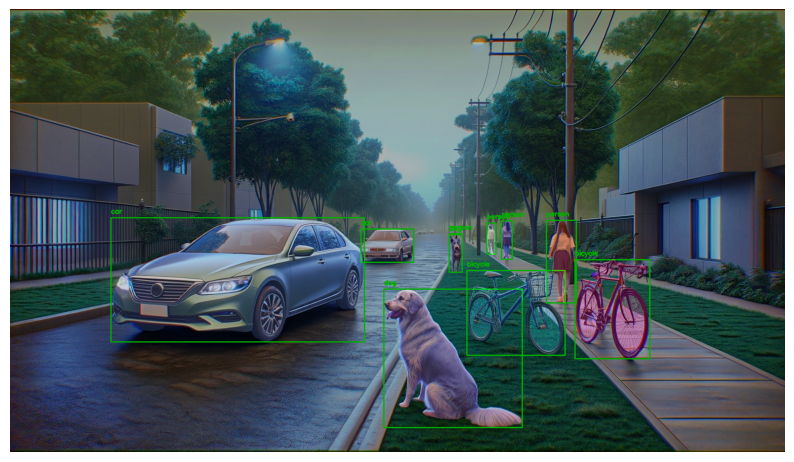

In [6]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.model import seg_sam, yolo_nas
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

image_path = test_img / "DALLE.jpeg"
class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

bboxes, confidence, labels, class_names, image = yolo_nas.get_object_detection(str(image_path))

# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
mask = mask_generator.generate(image)
seg_sam.show_anns(mask)

# Create a predictor for SAM
image = cv2.imread(str(test_img / "DALLE.jpeg"))
predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(
        image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
    )

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)


# Display the image
plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)  # Save the combined output
plt.show()

[2024-03-07 12:00:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-07 12:00:18] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
/Users/maryam/Library/Caches/pypoetry/virtualenvs/depth-aware-object-detection-zcMtcJV--py3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-03-07 12:00:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


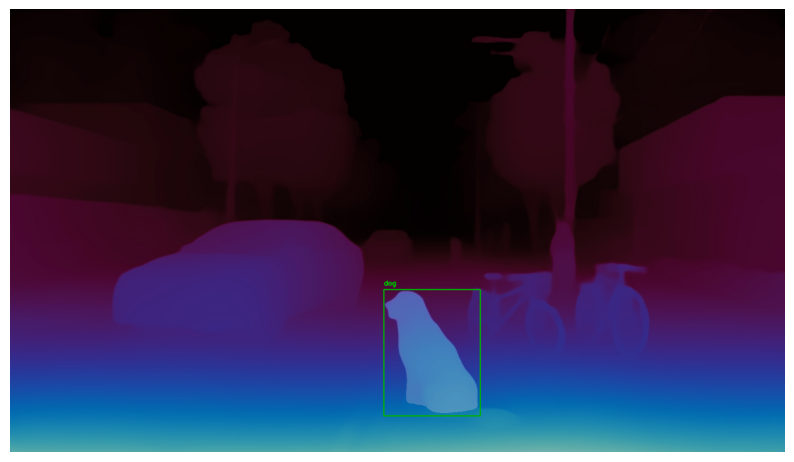

In [7]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.model import seg_sam, yolo_nas
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# image_path = output_img / "DALLE.jpeg"
class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

bboxes, confidence, labels, class_names, image = yolo_nas.get_object_detection(DepthAnything_colored)

# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
mask = mask_generator.generate(image)
seg_sam.show_anns(mask)

# Create a predictor for SAM
image = cv2.imread(str(output_img / "DA_DALLE_depth_colormap.jpg"))
predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(
        image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
    )

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)


# Display the image
plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)  # Save the combined output
plt.show()

[2024-03-07 12:03:56] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-03-07 12:03:56] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
/Users/maryam/Library/Caches/pypoetry/virtualenvs/depth-aware-object-detection-zcMtcJV--py3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-03-07 12:03:56] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


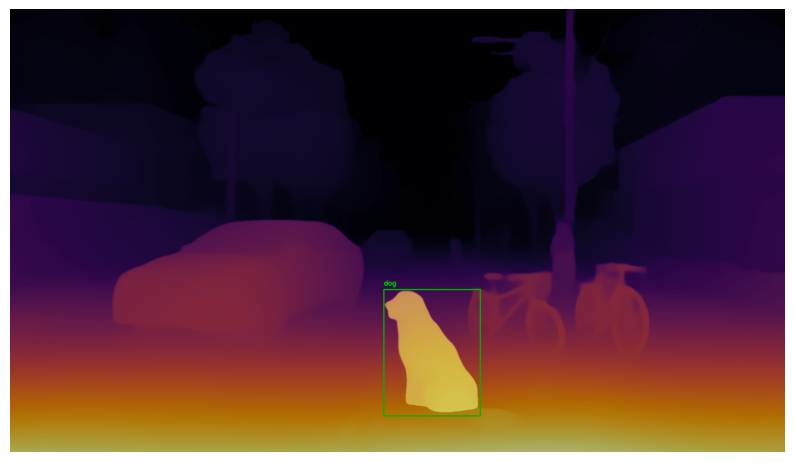

In [8]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np

from da_od.config import class_names, output_img, sam_weights
from da_od.model import seg_sam, yolo_nas
from da_od.segment_anything import SamAutomaticMaskGenerator, SamPredictor

# image_path = output_img / "DALLE.jpeg"
class_names_file = class_names / "coco.names.txt"
output_folder_path = output_img / "segmentation.jpg"
checkpoint_path = sam_weights / "sam_vit_h_4b8939.pth"


def read_class_names(file_path):
    with open(file_path) as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names


classNames = read_class_names(class_names_file)

bboxes, confidence, labels, class_names, image = yolo_nas.get_object_detection(DepthAnything_colored)

# Instantiate mask generator
mask_generator = SamAutomaticMaskGenerator(seg_sam.get_model(checkpoint_path))
mask = mask_generator.generate(image)
seg_sam.show_anns(mask)

# Create a predictor for SAM
# image = cv2.imread(str(output_img / "DA_DALLE_depth_colormap.jpg"))
predictor = SamPredictor(seg_sam.get_model(checkpoint_path))
predictor.set_image(image)

# Initialize a combined mask
combined_mask = np.zeros((image.shape[0], image.shape[1], 3))

# Loop through detections
for i, label in enumerate(labels):
    input_box = np.array(bboxes[i])

    # Predict mask using SAM
    mask, _, _ = predictor.predict(
        point_coords=None, point_labels=None, box=input_box[None, :], multimask_output=False
    )

    # Get the correct class label
    cls = int(label)
    class_name = classNames[cls]

    # Draw bounding box
    x_min, y_min, x_max, y_max = input_box
    cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

    # Add label
    cv2.putText(
        image, class_name, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
    )

    # Generate random color for mask
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    mask_color = np.array(random_color)

    # Add the mask to the combined mask with the random color
    combined_mask += mask[0][..., None] * mask_color

# Overlay the original image with the combined mask
final_image = cv2.addWeighted(image, 0.7, combined_mask.astype(np.uint8), 0.3, 0)


# Display the image
plt.close("all")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis("off")
plt.savefig(output_folder_path)  # Save the combined output
plt.show()